## Build two models using datasets with different numbers of features, compare their impact on predicted outcomes.
### Datasets:
#### Bel_30_min_2019_4features.csv (same features as the [Kaggle sample notebook](https://www.kaggle.com/code/giobbu/simple-lstm-tensorflow): 4 features)
#### Bel_30_min_2019_processed.csv (Our Spark processed data: 9 features)
### Output:
#### Two .pkl files saved predicted value lists and true value lists

In [1]:
# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pandas.testing as tm
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from os import walk
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
mpl.rcParams['figure.figsize'] = 20,10
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 1.5

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [30]:
number = int(input("Which dataset do you want to use? \nInput 1 to use 'Bel_30_min_2019_4features.csv' \nInput 2 to use 'Bel_30_min_2019_processed.csv' "))

Which dataset do you want to use? 
Input 1 to use 'Bel_30_min_2019_4features.csv' 
Input 2 to use 'Bel_30_min_2019_processed.csv' 2


In [31]:
### get data 
output_result_name = '9features_pred_results'
if number== 1:
    output_result_name = '4features_pred_results'
    df=pd.read_csv("/content/drive/My Drive/BD10/Bel_30_min_2019_4features.csv",parse_dates=['Datetime'],index_col="Datetime")
    f_cols1 = ['Hour_x','Hour_y','DayOfWeek','WorkingDays']
elif number== 2:
    df=pd.read_csv("/content/drive/My Drive/BD10/Bel_30_min_2019_processed.csv",parse_dates=['Datetime'],index_col="Datetime")
    f_cols1 = ['Hour','Minute','Second','Date','Month','Year','Day_Of_Week','Weekdays_Or_Weekend','Day_Or_Night']
else:
    print("Please input a valid number")

In [32]:
df.head()

,Sum_Traffic_Count,Day_Of_Week,Date,Month,Year,Hour,Minute,Second,Day_Or_Night,Weekdays_Or_Weekend
Datetime,,,,,,,,,,
2019-01-01 00:00:00,2391,3,1,1,2019,0,0,0,1,0
2019-01-01 00:30:00,2386,3,1,1,2019,0,30,0,1,0
2019-01-01 01:00:00,2428,3,1,1,2019,1,0,0,1,0
2019-01-01 01:30:00,2617,3,1,1,2019,1,30,0,1,0
2019-01-01 02:00:00,2068,3,1,1,2019,2,0,0,1,0


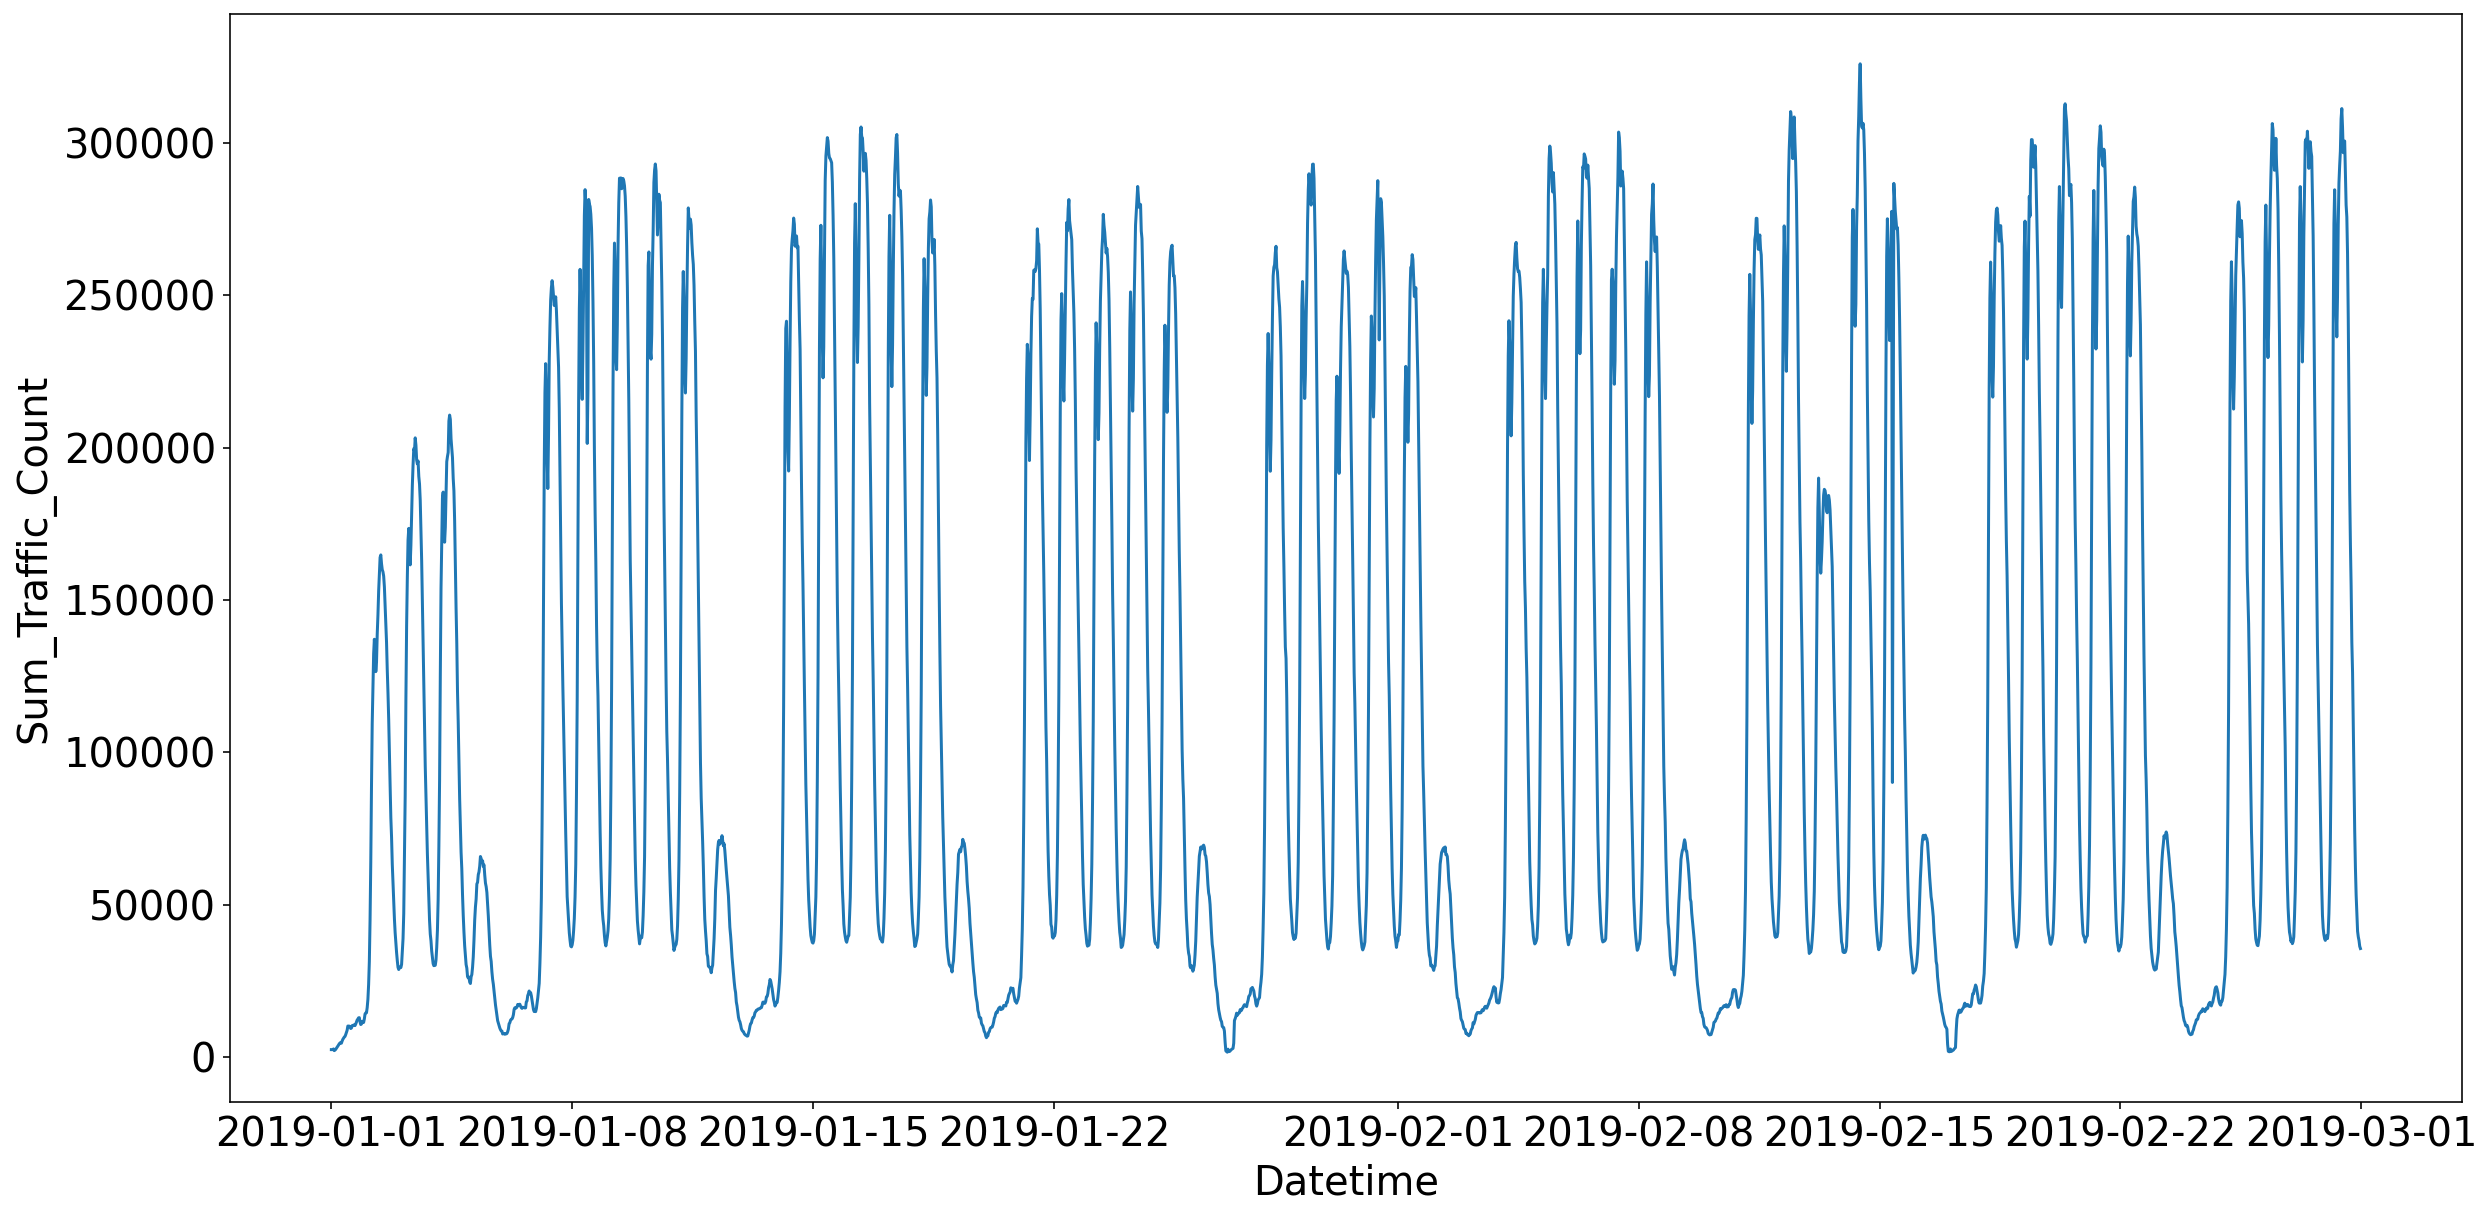

In [ ]:
sns.lineplot(x=df.index, y="Sum_Traffic_Count", data=df)

In [33]:
# Divide dataset to train set and test set
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

2265 567


In [34]:
# data normalization
from sklearn.preprocessing import RobustScaler

f_transformer1 = RobustScaler()
result_transformer = RobustScaler()

f_transformer1 = f_transformer1.fit(train[f_cols1].to_numpy())
result_transformer = result_transformer.fit(train[['Sum_Traffic_Count']])

train.loc[:, f_cols1] = f_transformer1.transform(train[f_cols1].to_numpy())
train['Sum_Traffic_Count'] = result_transformer.transform(train[['Sum_Traffic_Count']])

test.loc[:, f_cols1] = f_transformer1.transform(test[f_cols1].to_numpy())
test['Sum_Traffic_Count'] = result_transformer.transform(test[['Sum_Traffic_Count']])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [35]:
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        Ys.append(Y.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

In [36]:
# Create data set using shape(sample num, time step, features num)
TIME_STEPS = 24
x_train, y_train = create_dataset(train, train.Sum_Traffic_Count, time_steps = TIME_STEPS)
x_test, y_test = create_dataset(test, test.Sum_Traffic_Count, time_steps = TIME_STEPS)

In [37]:
print(x_test.shape, y_test.shape)

(543, 24, 10) (543,)


In [ ]:
# build LSTM model
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(x_train.shape[1], x_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# train data
epochs_value = 120
batch_size_value = 32

history = model.fit(
    x_train, y_train, 
    epochs=epochs_value, 
    batch_size=batch_size_value, 
    validation_split=0,
    shuffle=False
)

Epoch 1/120
71/71 [==============================] - 6s 17ms/step - loss: 0.2256 - mse: 0.0828
Epoch 2/120
71/71 [==============================] - 1s 17ms/step - loss: 0.1477 - mse: 0.0344
Epoch 3/120
71/71 [==============================] - 1s 16ms/step - loss: 0.1238 - mse: 0.0263
Epoch 4/120
71/71 [==============================] - 1s 16ms/step - loss: 0.1041 - mse: 0.0185
Epoch 5/120
71/71 [==============================] - 1s 16ms/step - loss: 0.1143 - mse: 0.0263
Epoch 6/120
71/71 [==============================] - 1s 17ms/step - loss: 0.0896 - mse: 0.0147
Epoch 7/120
71/71 [==============================] - 1s 17ms/step - loss: 0.0890 - mse: 0.0140
Epoch 8/120
71/71 [==============================] - 1s 17ms/step - loss: 0.0751 - mse: 0.0110
Epoch 9/120
71/71 [==============================] - 1s 16ms/step - loss: 0.0808 - mse: 0.0123
Epoch 10/120
71/71 [==============================] - 1s 20ms/step - loss: 0.0760 - mse: 0.0111
Epoch 11/120
71/71 [=============================

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 256)              142336    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 142,593
Trainable params: 142,593
Non-trainable params: 0
_________________________________________________________________
None


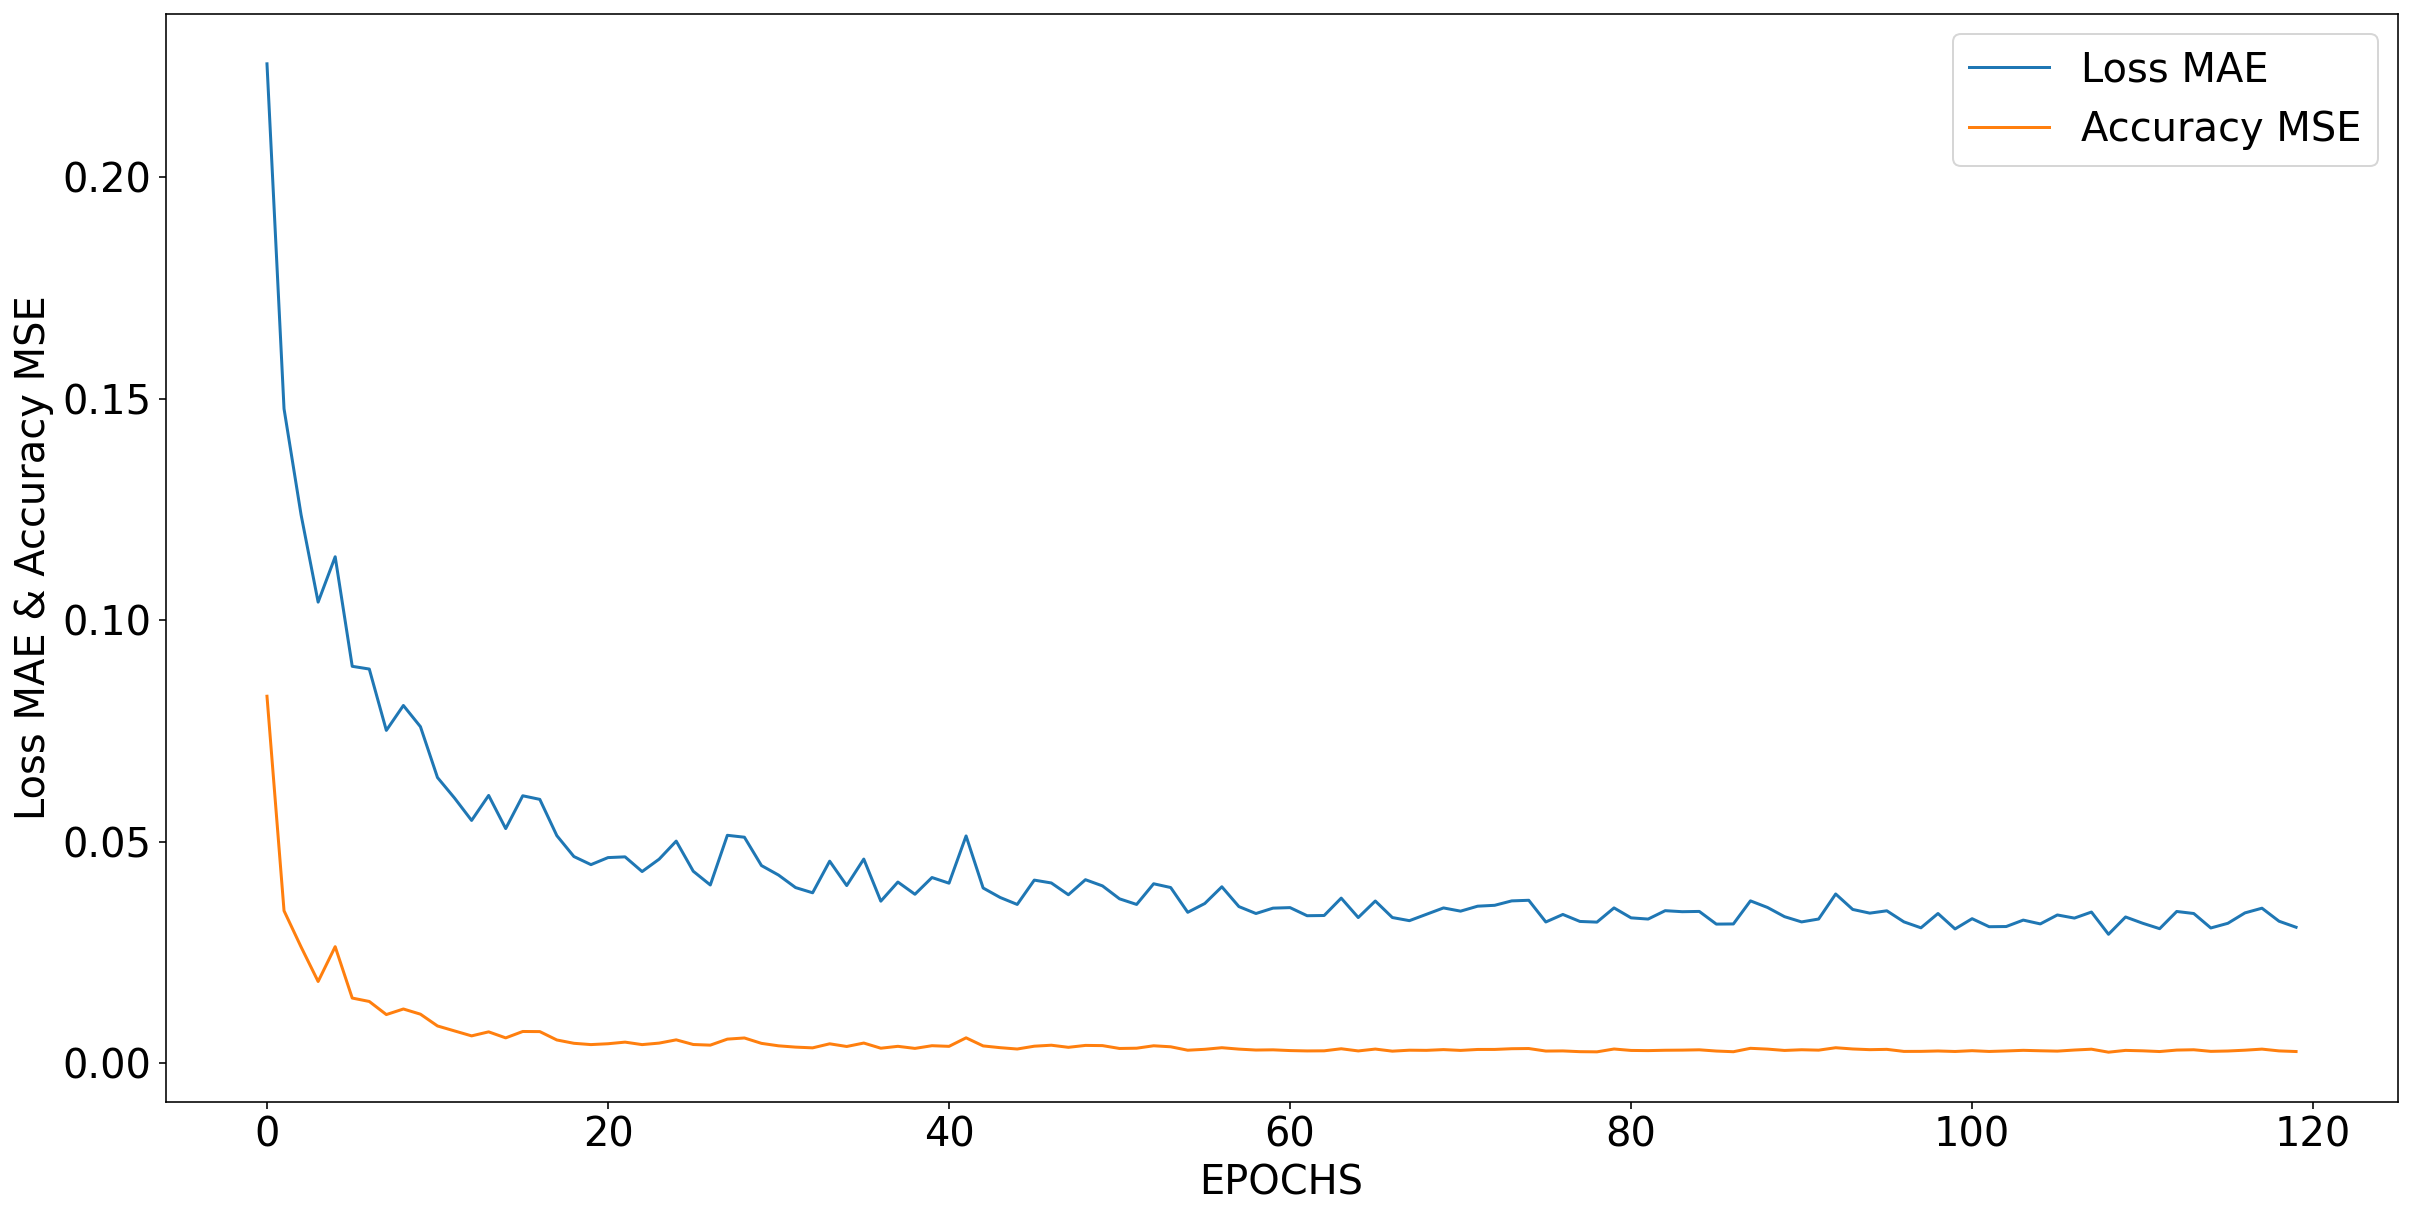

In [ ]:
# plot loss figure
print(model.summary())
model.save('/content/drive/My Drive/BD10/LSTM_' + output_result_name + '.h5')
plt.plot(history.history['loss'], label='Loss MAE')
plt.plot(history.history['mse'], label='Accuracy MSE')
plt.ylabel('Loss MAE & Accuracy MSE')
plt.xlabel('EPOCHS')
plt.legend()

In [38]:
from tensorflow.keras.models import load_model

model=load_model('/content/drive/My Drive/BD10/LSTM_' + output_result_name + '.h5')
y_pred = model.predict(x_test)

In [39]:
# data denormalization
y_train_inv = result_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = result_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = result_transformer.inverse_transform(y_pred)
# print the accuracy and MAE value
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
pred=y_pred_inv.flatten()
real=y_test_inv.flatten()

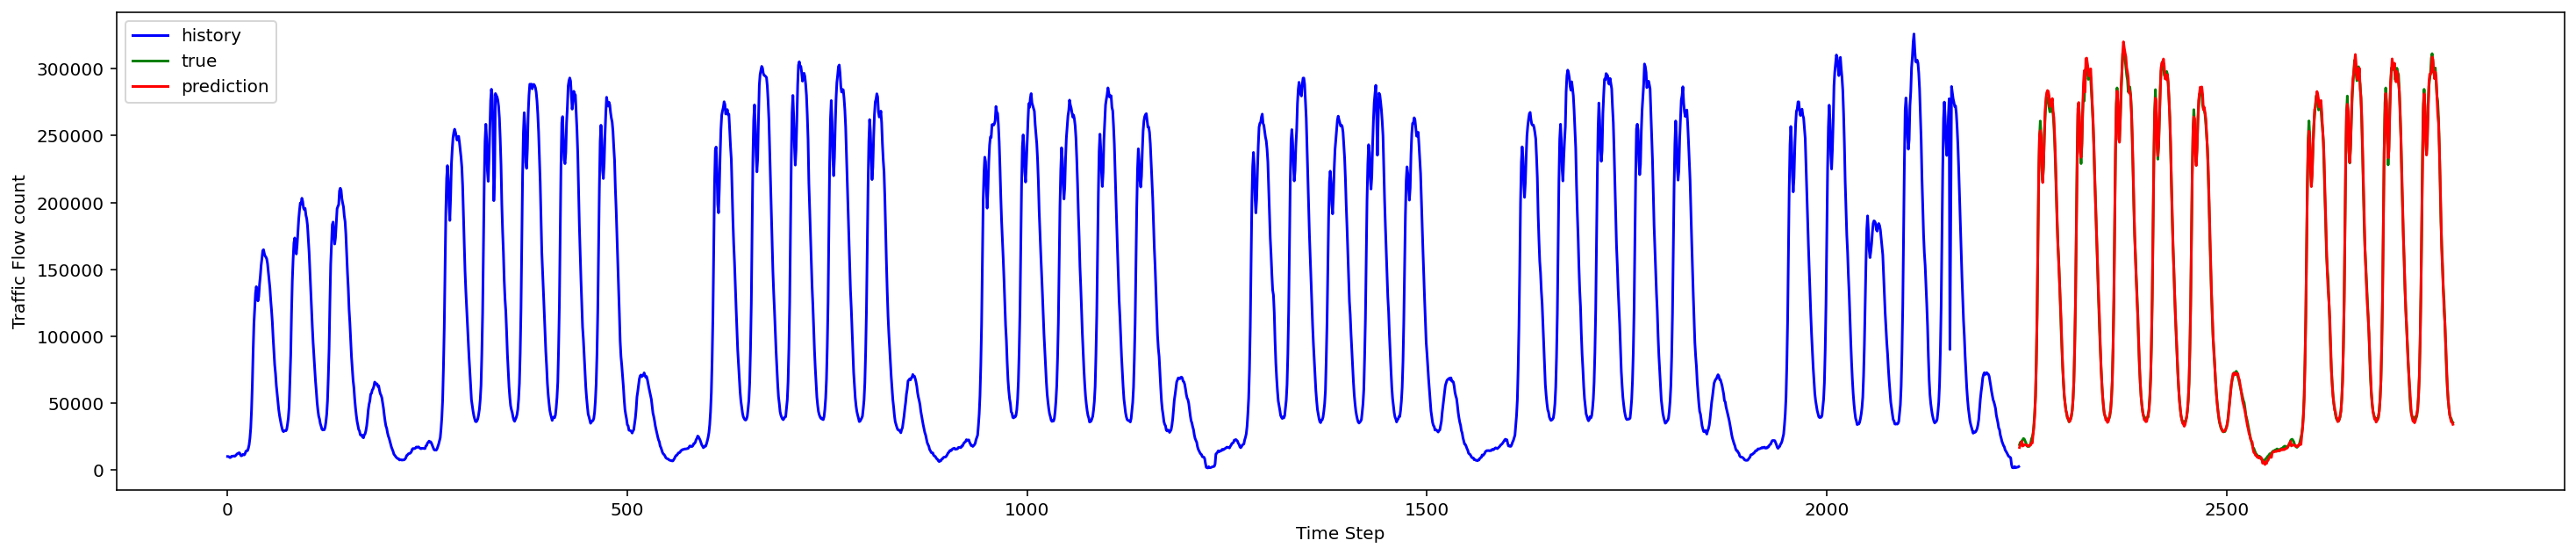

In [40]:
# Plot the predicted value, true value and history
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'b', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), real, color='g', label="true",)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), pred, 'r', label="prediction")
plt.ylabel('Traffic Flow count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

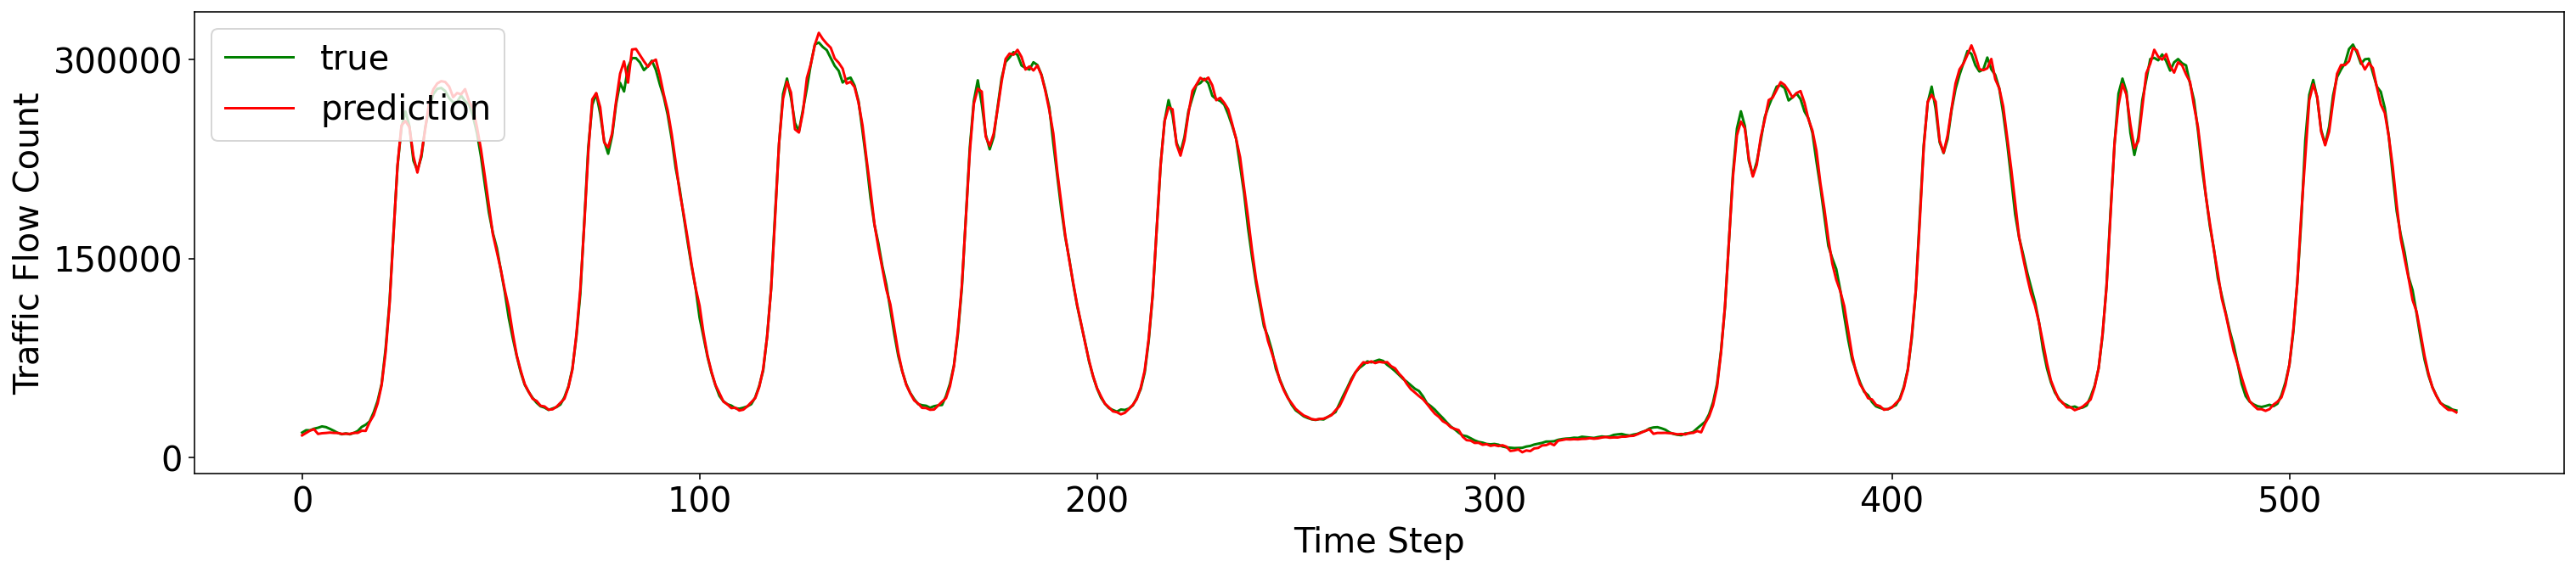

In [41]:
# Plot the predicted value and true value.
mpl.rcParams['figure.figsize'] = 25,5
plt.plot(real, color='g', label="true")
plt.plot(pred, 'r', label="prediction")
plt.ylabel('Traffic Flow Count',fontsize=20)
plt.xlabel('Time Step',fontsize=20)
plt.legend( loc='upper left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([0,150000,300000],fontsize=20)
plt.show();

In [ ]:
import pickle

# Saving the objects:
with open('/content/drive/My Drive/BD10/' + output_result_name + '.pkl', 'wb') as f:
    pickle.dump([real,pred], f)